Data rows: 505
                           day    net_flows  lock_tx_number  unlock_tx_number
0  2025-04-25 00:00:00.000 UTC  1100.000000               1                 0
1  2025-04-24 00:00:00.000 UTC  5773.854122              10                 2
2  2025-04-23 00:00:00.000 UTC  -930.000000               1                 3
3  2025-04-22 00:00:00.000 UTC  -349.898769               2                 1
4  2025-04-21 00:00:00.000 UTC  2060.000000               3                 0
Monthly rows: 16
                         day     net_flows  lock_tx_number  unlock_tx_number
5  2023-12-31 00:00:00+00:00  9.019904e+06              33                 6
6  2024-01-31 00:00:00+00:00  3.053748e+06              41                18
7  2024-02-29 00:00:00+00:00 -2.332256e+05              24                40
8  2024-03-31 00:00:00+00:00  2.070932e+05              25                25
9  2024-04-30 00:00:00+00:00 -4.882740e+04               4                20
10 2024-05-31 00:00:00+00:00  9.041130

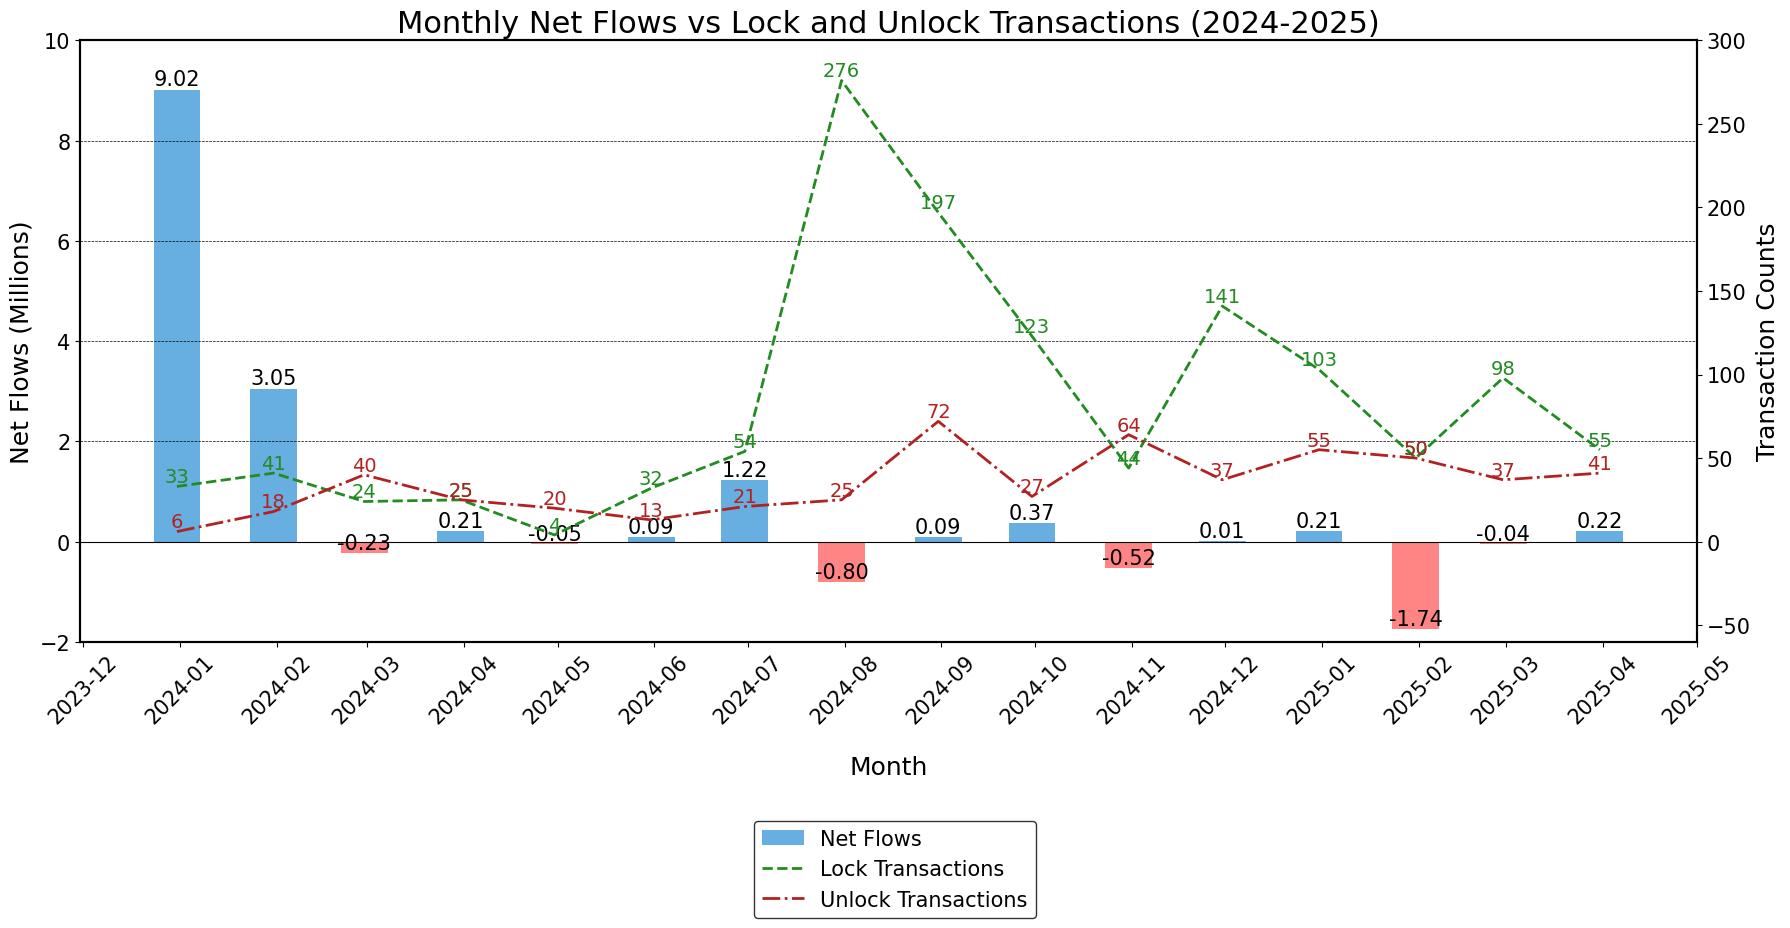

In [6]:
#!/usr/bin/env python3
# coding: utf-8

# ─── Imports & Environment ─────────────────────────────────────────────────────
from pathlib import Path
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
from dotenv import load_dotenv

# Load .env variables (for local dev); in CI, DUNE_API_KEY is injected
load_dotenv()

# ─── Resolve Paths ─────────────────────────────────────────────────────────────
cwd = Path().resolve()
if cwd.name == 'notebooks':
    NOTEBOOKS_DIR = cwd
    REPO_ROOT     = cwd.parent
else:
    REPO_ROOT     = cwd
    NOTEBOOKS_DIR = REPO_ROOT / 'notebooks'

# Data goes under notebooks/data/
data_dir = NOTEBOOKS_DIR / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

# Chart PNG goes under docs/assets/e7/
chart_dir = REPO_ROOT / 'docs' / 'assets' / 'e7'
chart_dir.mkdir(parents=True, exist_ok=True)

# ─── 1) Fetch data from Dune API ───────────────────────────────────────────────
api_key = os.environ['DUNE_API_KEY']
url     = "https://api.dune.com/api/v1/query/3988962/results/csv?limit=1000"
headers = {"X-Dune-API-Key": api_key}

resp = requests.get(url, headers=headers)
resp.raise_for_status()

# Save CSV to notebooks/data/output.csv
csv_path = data_dir / "output.csv"
with open(csv_path, "wb") as f:
    f.write(resp.content)

# ─── 2) Load & preprocess ─────────────────────────────────────────────────────
data = pd.read_csv(csv_path)
print(f"Data rows: {len(data)}")
print(data.head())

# Ensure 'day' is datetime
data['day'] = pd.to_datetime(data['day'])

# Aggregate end-of-month sums
monthly_data = (
    data
    .resample('ME', on='day')
    .agg({
        'net_flows': 'sum',
        'lock_tx_number': 'sum',
        'unlock_tx_number': 'sum'
    })
    .reset_index()
)

# Filter years and date
monthly_data = monthly_data[monthly_data['day'].dt.year.isin([2024, 2025])]
# Shift to first of month
monthly_data.loc[:, 'day'] = monthly_data['day'] - MonthEnd(1)
# Only before end-April-2025
monthly_data = monthly_data[monthly_data['day'] < '2025-04-30']

print(f"Monthly rows: {len(monthly_data)}")
print(monthly_data)

# ─── 3) Plot (light theme only) ────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(18, 8))

# Theme settings
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
text_color = 'black'
net_flows_color_positive = '#007ACC'
net_flows_color_negative = '#FF3333'
line_color_lock = '#228B22'
line_color_unlock = '#B22222'
legend_facecolor = 'white'
legend_edgecolor = 'black'
spine_color = 'black'

# Style spines
for pos in ['top', 'bottom', 'left', 'right']:
    ax1.spines[pos].set_color(spine_color)
    ax1.spines[pos].set_linewidth(1.5)

# Bar chart: net_flows
bar_width = 15  # days
colors = [
    net_flows_color_negative if v < 0 else net_flows_color_positive
    for v in monthly_data['net_flows']
]
bars = ax1.bar(
    monthly_data['day'],
    monthly_data['net_flows'] / 1e6,
    width=bar_width,
    color=colors,
    label='Net Flows',
    alpha=0.6
)

# Axes labels & ticks
ax1.set_xlabel('Month', color=text_color, fontsize=18, labelpad=20)
ax1.set_ylabel('Net Flows (Millions)', color=text_color, fontsize=18)
ax1.tick_params(axis='y', labelcolor=text_color, colors=text_color, labelsize=15)
ax1.tick_params(axis='x', colors=text_color, labelsize=15)
ax1.set_ylim(-2, 10)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, color=text_color)

# Zero line
ax1.axhline(0, color=spine_color, linewidth=0.8)

# Bar labels
for bar in bars:
    h = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f'{h:.2f}',
        ha='center',
        va='bottom',
        fontsize=15,
        color=text_color
    )

# Grid lines
ax1.grid(axis='y', color=spine_color, linewidth=0.5, linestyle='--')

# ─── 4) Secondary axis for lock/unlock tx ─────────────────────────────────────
ax2 = ax1.twinx()
line1, = ax2.plot(
    monthly_data['day'],
    monthly_data['lock_tx_number'],
    color=line_color_lock,
    label='Lock Transactions',
    linestyle='--',
    linewidth=2
)
line2, = ax2.plot(
    monthly_data['day'],
    monthly_data['unlock_tx_number'],
    color=line_color_unlock,
    label='Unlock Transactions',
    linestyle='-.',
    linewidth=2
)

# Style ax2 spines
for pos in ['top', 'bottom', 'left', 'right']:
    ax2.spines[pos].set_color(spine_color)
    ax2.spines[pos].set_linewidth(1.5)

ax2.set_ylim(-60, 300)
ax2.set_ylabel('Transaction Counts', color=text_color, fontsize=18)
ax2.tick_params(axis='y', labelcolor=text_color, labelsize=15)
ax2.spines['right'].set_color(text_color)
ax2.spines['left'].set_color(text_color)

# Line labels
for x, y in zip(monthly_data['day'], monthly_data['lock_tx_number']):
    ax2.text(x, y, f'{y}', ha='center', va='bottom', fontsize=14, color=line_color_lock)
for x, y in zip(monthly_data['day'], monthly_data['unlock_tx_number']):
    ax2.text(x, y, f'{y}', ha='center', va='bottom', fontsize=14, color=line_color_unlock)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
all_lines = lines1 + lines2
all_labels = labels1 + labels2

fig.legend(
    all_lines,
    all_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=1,
    facecolor=legend_facecolor,
    edgecolor=legend_edgecolor,
    fontsize=15
)
for text in fig.legends[0].get_texts():
    text.set_color(text_color)

plt.title(
    'Monthly Net Flows vs Lock and Unlock Transactions (2024-2025)',
    color=text_color,
    fontsize=22
)
plt.tight_layout()

# ─── 5) Save & close ───────────────────────────────────────────────────────────
out_path = chart_dir / 'octant_tx_month.png'
plt.savefig(out_path, bbox_inches='tight')
plt.show()
plt.close(fig)
